# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
matplotlib 3.0.1
statsmodels 0.9.0
sklearn 0.20.2

compiler   : MSC v.1912 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : AMD64 Family 16 Model 2 Stepping 3, AuthenticAMD
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function

import itertools
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import timeit
import warnings

from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from time import time
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Поменяйте на свой путь к данным
# Path to HW09 files
PATH_TO_DATA = os.path.join(os.path.dirname(os.path.abspath(os.curdir)),'HW09')
PATH_TO_DATA

'C:\\Users\\philka-ua\\geekhubds\\HW09'

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [9]:
from sklearn import model_selection, datasets, linear_model, metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate

In [10]:
%%time
# Logistic Regression model
logit = LogisticRegression(random_state=17)
logit.fit(X_train, y_train)
predictions_logit = logit.predict(X_valid)

# Linear Regression model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)
predictions_linear = linear_regressor.predict(X_valid)

Wall time: 5min 11s


In [11]:
# Mean absolute error and Score
print(f'\nLogistic: mean absolute error {metrics.mean_absolute_error(y_valid, predictions_logit):.3} ')
print(f'Linear: mean absolute error {metrics.mean_absolute_error(y_valid, predictions_linear):.3} \n ')

# Use score method to get accuracy of model
score_linear = linear_regressor.score(X_valid, y_valid)
score_logistic = logit.score(X_valid, y_valid)

print(f'Score: linear regression {score_linear:.3}')
print(f'Score: logistic regression {score_logistic:.3}')


Logistic: mean absolute error 0.79 
Linear: mean absolute error 1.37 
 
Score: linear regression 0.34
Score: logistic regression 0.762


In [12]:
%%time
# Cross-valiadations scores
# https://scikit-learn.org/stable/modules/cross_validation.html

cvs_score_logistic = cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1).mean()
cvs_score_linear = cross_val_score(linear_regressor, X_train, y_train, cv=skf, n_jobs=-1).mean()

print(f'Score CV: linear regression {cvs_score_linear:.3}')
print(f'Score CV: logistic regression {cvs_score_logistic:.3}')

Score CV: linear regression -0.29
Score CV: logistic regression 0.738
Wall time: 1min 52s


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [13]:
%%time
logit_c_values1 = np.logspace(1e-4, 1e2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial',\
                                            random_state=17, cv=skf, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 11s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [15]:
# C values
c_values = logit_grid_searcher1.Cs_

# CV scores (for 1 class other the same)
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[1].mean(axis=0)

print(f'CV score values:\n {logit_mean_cv_scores1} \n')

# # NOT Multiclass
# # CV scores
# logit_grid_searcher1_mean_scores = [*map(lambda x: x.mean(axis=0), logit_grid_searcher1.scores_.values())]

# # Index for max score mean(elements)
# index_max_mean_score = max( enumerate(map(lambda x: x.mean(), logit_grid_searcher1_mean_scores)) , key=lambda x:x[1])[0]

# # C values
# c_values = logit_grid_searcher1.Cs_
# C_values_round = list( map(lambda x: round(x, 5), map(float, c_values)) )

# print(f'C values: {C_values_round}')

CV score values:
 [0.75432225 0.75036264 0.75198859 0.75005785 0.75026046 0.74954867
 0.74833132 0.7477212  0.74731581 0.74629865] 



Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [17]:
print(f'Max CV score: {logit_mean_cv_scores1.max():.5f}\
    C value: {logit_grid_searcher1.Cs_[logit_mean_cv_scores1.argmax()]:.5f}')

# print(f'Max CV score: {logit_grid_searcher1_mean_scores[index_max_mean_score].max():.5f}\
#     C value: {logit_grid_searcher1.Cs_[index_max_mean_score]}')

Max CV score: 0.75432    C value: 1.00023


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

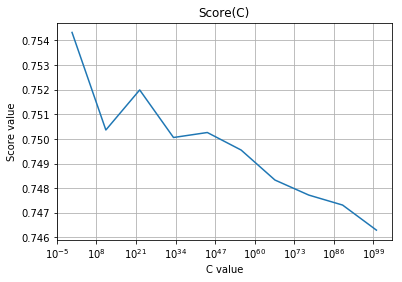

In [18]:
# Graphics
plt.semilogx(logit_c_values1, logit_mean_cv_scores1)
plt.title('Score(C)')
plt.xlabel('C value')
plt.ylabel('Score value')
plt.grid(True)

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [19]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', random_state=17,\
                                            cv=skf, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 2min 32s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [20]:
# C values
c_values = logit_grid_searcher2.Cs_

# CV scores (for 1 class other the same)
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[1].mean(axis=0)

print(f'CV score values:\n {logit_mean_cv_scores2} \n')

CV score values:
 [0.75483063 0.75158187 0.75168474 0.74975273 0.74995685 0.74954957
 0.74843422 0.7469084  0.7465036  0.74650357 0.74528517 0.74487842
 0.74457385 0.74487823 0.74426897 0.74447201 0.74406569 0.74568945
 0.74518129 0.74487669] 



Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [21]:
print(f'Max CV score: {logit_mean_cv_scores2.max():.5f}\
    C value: {logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]:.5f}')

Max CV score: 0.75483    C value: 0.10000


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

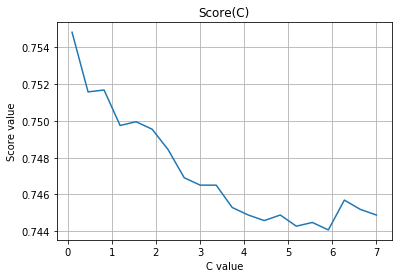

In [22]:
plt.plot(logit_c_values2, logit_mean_cv_scores2)
plt.title('Score(C)')
plt.xlabel('C value')
plt.ylabel('Score value')
plt.grid(True)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [22]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher1.predict(X_valid))

print(f'Accuracy score: {logit_cv_acc:.5f}')

Accuracy score: 0.78573


**<font color='red'>Вопрос 1. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [23]:
print(f'Max CV score: {logit_mean_cv_scores2.max():.3f}  Accurasy test on y_valid: {logit_cv_acc:.3f}')


Max CV score: 0.754  Accurasy test on y_valid: 0.786


**2. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [24]:
from sklearn.svm import LinearSVC

In [25]:
svm = LinearSVC(random_state=17)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [26]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 2s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [27]:
print(f'Max CV score: {svm_grid_searcher1.best_score_:.5f}  C value: {svm_grid_searcher1.best_estimator_.C:.5f}')

Max CV score: 0.72861  C value: 0.00010


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

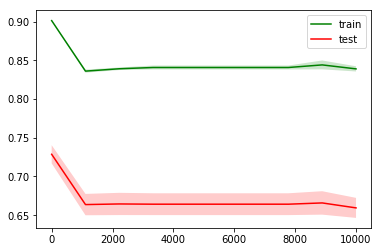

In [28]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [29]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 2min 45s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [30]:
print(f'Max CV score: {svm_grid_searcher2.best_score_:.5f}  C value: {svm_grid_searcher2.best_estimator_.C:.5f}')

Max CV score: 0.71012  C value: 0.00100


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

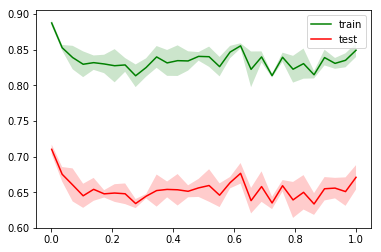

In [31]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [32]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher1.predict(X_valid))

print(f'Accuracy score: {svm_cv_acc:.5f}')

Accuracy score: 0.76061


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [33]:
print(f'Max CV score: {svm_grid_searcher2.best_score_:.3f}  Accurasy test on y_valid: {svm_cv_acc:.3f}')

Max CV score: 0.710  Accurasy test on y_valid: 0.761


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [34]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, rand_state=17, test_sz=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    start_time = timeit.default_timer()
    
    # open pkl files with PATH_TO_DATA
    with open(os.path.join(PATH_TO_DATA, path_to_X_pickle), 'rb') as X_pkl:
        X_users = pickle.load(X_pkl)
    with open(os.path.join(PATH_TO_DATA, path_to_y_pickle), 'rb') as y_pkl:
        y_users = pickle.load(y_pkl)
    
    # split data
    X_train, X_valid, y_train, y_valid = train_test_split(X_users, y_users, 
                                         test_size=test_sz, random_state=rand_state, stratify=y_users)
    
    # fitting data
    estimator.fit(X_train, y_train)
    
    # CV score 
    cv_score_mean = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1).mean()
    
    # Accuracy 
    acuracy_score_result = accuracy_score(y_valid, estimator.predict(X_valid))

    
    end_time = (timeit.default_timer() - start_time)/60
    
    return cv_score_mean, acuracy_score_result, end_time

**Убедитесь, что функция работает.**

In [35]:
model_assessment(svm_grid_searcher2.best_estimator_,'X_sparse_10users.pkl','y_10users.pkl', skf)

(0.7101262915969002, 0.7371415027257644, 0.2926879331333339)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [ ]:
# !cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [36]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = 'X_sparse_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = 'y_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
        
        print(f'\nSession size: {session_length}    Window size: {window_size}')
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))



Session size: 15    Window size: 10
(0.728389651554811, 0.7464454976303317, 0.01064937685000018)

Session size: 10    Window size: 10
(0.7101262915969002, 0.7371415027257644, 0.2932874143499987)

Session size: 15    Window size: 7
(0.7468187345025141, 0.7619442601194426, 0.014741754299999835)

Session size: 10    Window size: 7
(0.6851333837923536, 0.7033349925335988, 0.01200511191666654)

Session size: 7    Window size: 7
(0.6283046598873728, 0.6485813837730214, 0.010748393433334513)

Session size: 15    Window size: 5
(0.7707636138454546, 0.7824128940507229, 0.024187180050000735)

Session size: 10    Window size: 5
(0.7047504460028184, 0.7226502311248074, 0.020028284116665417)

Session size: 7    Window size: 5
(0.6491405937859052, 0.6687603697558663, 0.018189630666665835)

Session size: 5    Window size: 5
(0.5963315219488473, 0.6168800379326695, 0.016250195283333824)
Wall time: 25.2 s


**<font color='red'>Вопрос 3. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [37]:
%%time
cv_scores, accuracy_scores, eval_time = model_assessment(svm_grid_searcher2.best_estimator_, 
                                        'X_sparse_10users_s15_w5.pkl','y_10users_s15_w5.pkl', skf)

print(f'\nCV score: {cv_scores:.3f}    Accuracy score: {accuracy_scores:.3f}')


CV score: 0.771    Accuracy score: 0.782
Wall time: 1.65 s


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [38]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = 'X_sparse_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
    path_to_y_pkl = 'y_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl'
        
    print(f'\nSession size: {session_length}    Window size: {window_size}')
    print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))


Session size: 5    Window size: 5
(0.326315430254784, 0.3413515355039665, 12.216923649466668)

Session size: 7    Window size: 7
(0.3491800498149031, 0.36653949654256224, 5.214321602149997)

Session size: 10    Window size: 10
(0.36524415384328096, 0.38600204349729966, 146.64915657953333)
Wall time: 2h 44min 4s


In [39]:
print('If session and window sizes will be equal, we get score 0.32 - 0.34,\
it shows that we have to change alignment -  \nSession size > Window size to get more score value')

If session and window sizes will be equal, we get score 0.32 - 0.34,it shows that we have to change alignment -  
Session size > Window size to get more score value


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [40]:
%%time
cv_scores, accuracy_scores, eval_time = model_assessment(svm_grid_searcher2.best_estimator_, 
                                        'X_sparse_150users.pkl','y_150users.pkl', skf)

print(f'\nCV score: {cv_scores:.3f}   Accuracy score: {accuracy_scores:.3f}')


CV score: 0.365   Accuracy score: 0.386
Wall time: 2h 56min 9s


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [41]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [42]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [43]:
%%time

# defining C value
C_value = logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]
print(f'C value: {C_value:.5f}')

# estimator + fitting model
logit_cv_150users = LogisticRegressionCV(Cs=[C_value], cv=skf, random_state=17,  multi_class='ovr', n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

C value: 0.10000
Wall time: 43min 10s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [44]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user.update({user_id: logit_cv_150users.scores_[user_id].mean()})
    print(f'User: {user_id}  CV score: {logit_cv_150users.scores_[user_id].mean()}')

User: 1  CV score: 0.9948287691951373
User: 2  CV score: 0.9958708412308215
User: 3  CV score: 0.9935878111197464
User: 4  CV score: 0.9903561097872986
User: 5  CV score: 0.9888650645115012
User: 6  CV score: 0.9914095535009229
User: 7  CV score: 0.9929314389022869
User: 8  CV score: 0.9833182716064509
User: 9  CV score: 0.99718503373478
User: 10  CV score: 0.9943596261513775
User: 11  CV score: 0.9925772693638472
User: 12  CV score: 0.9926393089254079
User: 13  CV score: 0.9956315696532007
User: 14  CV score: 0.9933482659303321
User: 15  CV score: 0.9950997380838151
User: 16  CV score: 0.9952244521249193
User: 17  CV score: 0.9880517186245429
User: 18  CV score: 0.9930878696146203
User: 19  CV score: 0.993431287398927
User: 20  CV score: 0.9898451230820272
User: 21  CV score: 0.9784693358435662
User: 22  CV score: 0.9964239476792068
User: 23  CV score: 0.9937447479650884
User: 24  CV score: 0.9901162004474139
User: 25  CV score: 0.9958088549097343
User: 26  CV score: 0.992763847677294

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [45]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    
    # share of correct answers
    correct_answers_in_all = (class_distr.sum() - class_distr[user_id]) / class_distr.sum()
        
    # difference evaluation
    acc_diff_vs_constant.append(cv_scores_by_user[user_id].mean() - correct_answers_in_all)
    
    print(f'User: {user_id}    share of correct answers: {correct_answers_in_all:.5f} \
    difference: {(cv_scores_by_user[user_id].mean() - correct_answers_in_all):.5f}')

User: 1    share of correct answers: 0.98440     difference: 0.01043
User: 2    share of correct answers: 0.99570     difference: 0.00017
User: 3    share of correct answers: 0.99440     difference: -0.00081
User: 4    share of correct answers: 0.98472     difference: 0.00564
User: 5    share of correct answers: 0.98795     difference: 0.00092
User: 6    share of correct answers: 0.99445     difference: -0.00304
User: 7    share of correct answers: 0.99255     difference: 0.00039
User: 8    share of correct answers: 0.98391     difference: -0.00059
User: 9    share of correct answers: 0.99712     difference: 0.00006
User: 10    share of correct answers: 0.99383     difference: 0.00053
User: 11    share of correct answers: 0.99415     difference: -0.00157
User: 12    share of correct answers: 0.99204     difference: 0.00059
User: 13    share of correct answers: 0.99692     difference: -0.00129
User: 14    share of correct answers: 0.99486     difference: -0.00151
User: 15    share of co

**<font color='red'>Вопрос 5. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [46]:
more_constant_predict = (np.array(acc_diff_vs_constant) > 0).sum()
print(f'proportion of users: {(more_constant_predict/len(acc_diff_vs_constant) * 100):.3f} %')

proportion of users: 33.333 %


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [47]:
y_binary_128 = np.isin(y_150users,1).astype('int')
print('Quantity user 1: ',y_binary_128.sum())

Quantity user 1:  2137


In [48]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [49]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, 
                               train_sizes=train_sizes, cv=skf, n_jobs=-1)

Wall time: 3min 21s


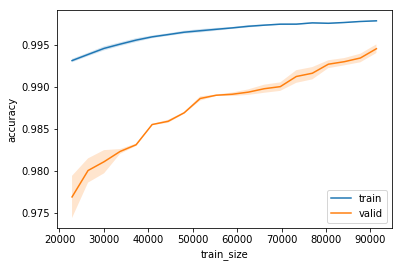

In [50]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

In [51]:
print('Model is trained, and some increasing of training size will not increase accuracy much')

Model is trained, and some increasing of training size will not increase accuracy much
